# Example: History Analytics with dashDB (cold data)
## written in Python
Perform rather complex analytics with historical data to find patterns and new insights!

In [75]:
from IPython.display import HTML
HTML('''<style>
//custom style
</style>
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [76]:
from pyspark.sql import  SQLContext
sqlContext=SQLContext(sc)

In [77]:
import pandas as pd

Timestamps and dates:

In [78]:
import datetime, time
# create current timestamp
ts = time.time()
# convert into UTC
curr_dt = datetime.datetime.utcfromtimestamp(ts)
curr_date = curr_dt.date()
# create start of week date
tsl = ts - 7*24*60*60
week_dt = datetime.datetime.utcfromtimestamp(tsl)
week_date= week_dt.date()
print "timezone:              ",time.tzname
print "current timestamp (tz):",ts
print "current datetime (utc):",curr_dt
print "current date     (utc):",curr_date
print "date a week ago  (utc):",week_date

timezone:               ('CST', 'CDT')
current timestamp (tz): 1466538769.95
current datetime (utc): 2016-06-21 19:52:49.950885
current date     (utc): 2016-06-21
date a week ago  (utc): 2016-06-14


Read previously saved parquet file and register it as a table named "data"

In [79]:
%matplotlib inline
parquetFile = sqlContext.read.parquet("swift://my-container.spark/simdata.parquet")
parquetFile.registerTempTable("data")

Here you can filter your dataset in advance.

In this example we want to use all the data that is available.

In [80]:
df = sqlContext.sql("SELECT * FROM data")

In [81]:
print "Count:",df.count()

Count: 8134


In [82]:
# deduplicate
# dedup = df.toPandas()
# dedup = dedup.drop_duplicates()
# df = sqlContext.createDataFrame(dedup)
# print "Count after deduplication:",df.count()

In [83]:
df_date = df.withColumn('DATE', df.TS[0:10])
df_date = df_date.withColumn('YEAR', df.TS[0:4])
df_date = df_date.withColumn('MONTH', df.TS[6:2])
panda = df_date.toPandas()

Table first 5 rows

In [84]:
panda.head()

,TS,TEMPERATURE,LIGHT,DOOROPEN,WINDOWOPEN,HUMIDITY,OXYGEN,WATERCONSUMPTION,ENERGYCONSUMPTION,DATE,YEAR,MONTH
0,2016-05-31T10:21:11.855Z,10,50,0,0,7,45,87,23,2016-05-31,2016,05
1,2016-05-31T10:22:11.868Z,19,514,0,0,51,20,10,10,2016-05-31,2016,05
2,2016-05-31T10:23:11.884Z,18,486,0,0,45,21,9,10,2016-05-31,2016,05
3,2016-05-31T10:24:11.893Z,20,485,0,0,45,21,9,10,2016-05-31,2016,05
4,2016-05-31T10:25:11.909Z,18,505,0,0,45,20,9,10,2016-05-31,2016,05


Table last 5 rows

In [85]:
panda.tail()

,TS,TEMPERATURE,LIGHT,DOOROPEN,WINDOWOPEN,HUMIDITY,OXYGEN,WATERCONSUMPTION,ENERGYCONSUMPTION,DATE,YEAR,MONTH
8129,2016-06-16T20:39:44.297Z,18,489,0,0,49,20,9,10,2016-06-16,2016,06
8130,2016-06-16T20:39:44.297Z,18,489,0,0,49,20,9,10,2016-06-16,2016,06
8131,2016-06-16T20:39:44.297Z,18,489,0,0,49,20,9,10,2016-06-16,2016,06
8132,2016-06-16T20:40:44.298Z,21,500,0,0,45,20,9,9,2016-06-16,2016,06
8133,2016-06-16T20:40:44.298Z,21,500,0,0,45,20,9,9,2016-06-16,2016,06


In [86]:
# create table with data from this day
#sameday = panda[panda['DATE']==curr_date]
sameday = df_date[df_date.DATE == curr_date]
sdcount = sameday.count()
print "Amount rows today: " , sdcount

Amount rows today:  0


In [87]:
#create table with data from this week
weekdays = df_date[df_date.DATE >= week_date]
wdcount = weekdays.count()
print "Amount rows week: " , wdcount

Amount rows week:  2477


# Questions

### Overview

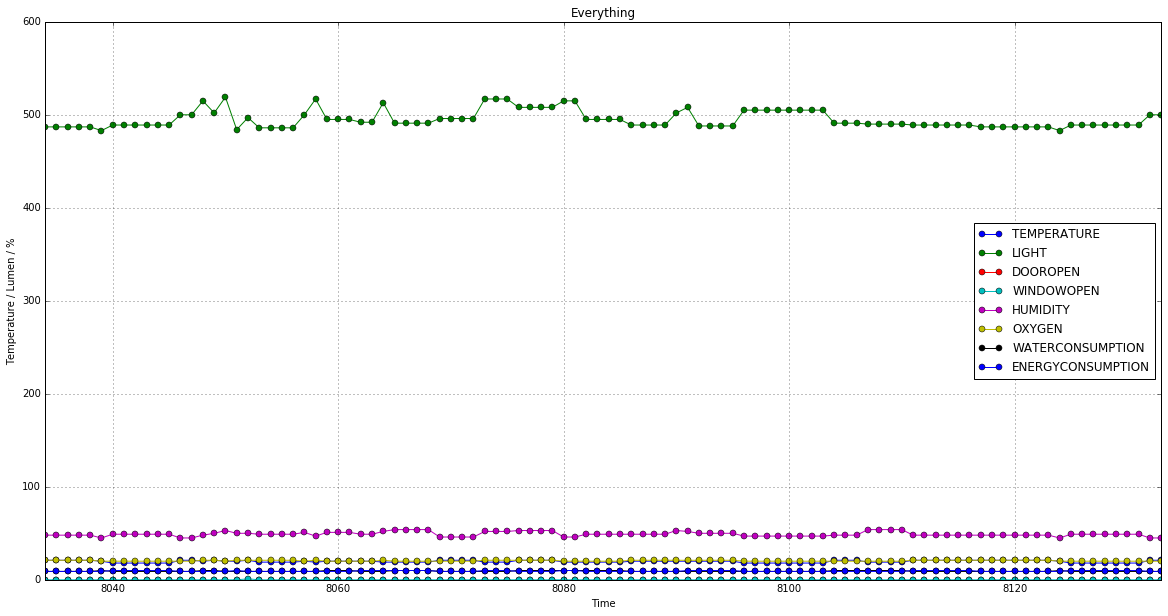

In [88]:
panda_overview = panda.tail(100)
ax1 = panda_overview.plot(figsize=(20,10), marker='o', linestyle='-', title="Everything")
ax1.set_ylabel("Temperature / Lumen / %")
ax1.set_xlabel("Time")
ax1.yaxis.grid()
ax1.xaxis.grid()

## 1) What are the trends?

In [89]:
import requests, StringIO, pandas as pd, json, re
import matplotlib.pyplot as plt, numpy as np

In [102]:
temp = panda["TEMPERATURE"]
humidity = panda["HUMIDITY"]
energy = panda["ENERGYCONSUMPTION"]
water = panda["WATERCONSUMPTION"]

In [103]:
def compute_trend(data, title, yax):
    # linear regression with polyfit
    fit = np.polyfit(data.index, data, 1)
    fit_fn = np.poly1d(fit)
    print "function:" ,fit_fn
    # printing data and linear regression line
    plt.figure(figsize=(20,5))
    plt.plot(data.index, data, '.', data.index, fit_fn(data.index), '--r')
    plt.title(title+" Trend")
    plt.xlabel("Time")
    plt.ylabel(yax)
    plt.show()

function:  
-2.741e-06 x + 19.5


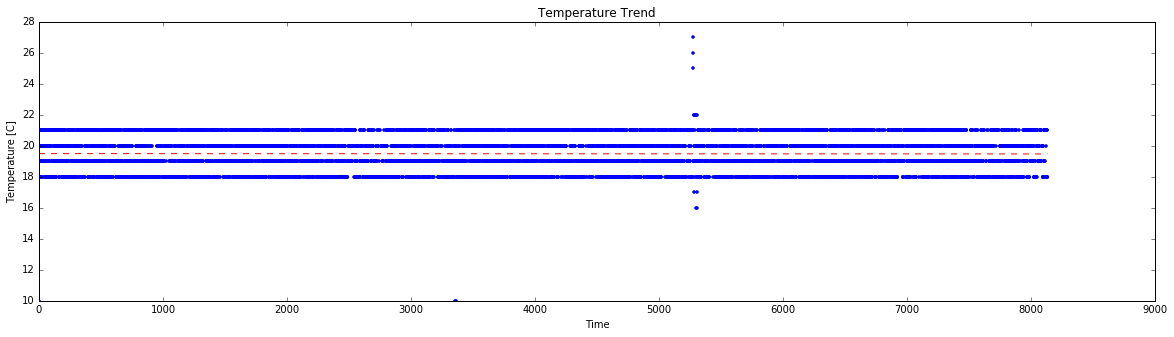

function:  
-1.25e-05 x + 49.51


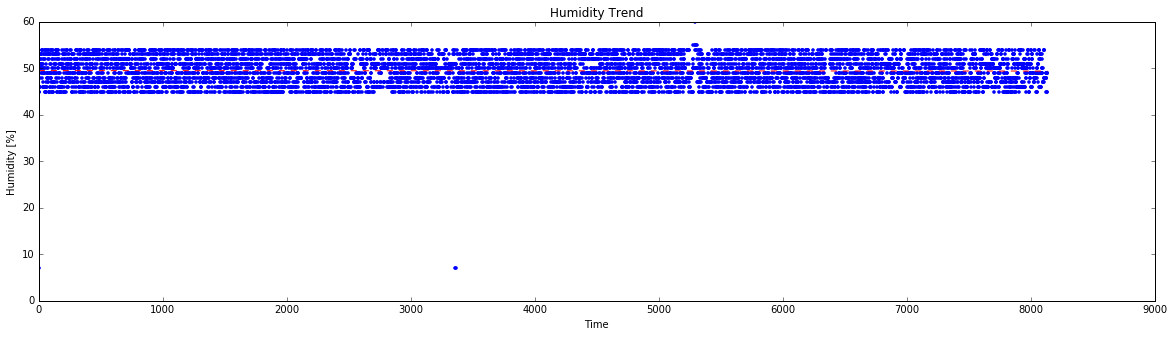

function:  
-6.265e-06 x + 9.522


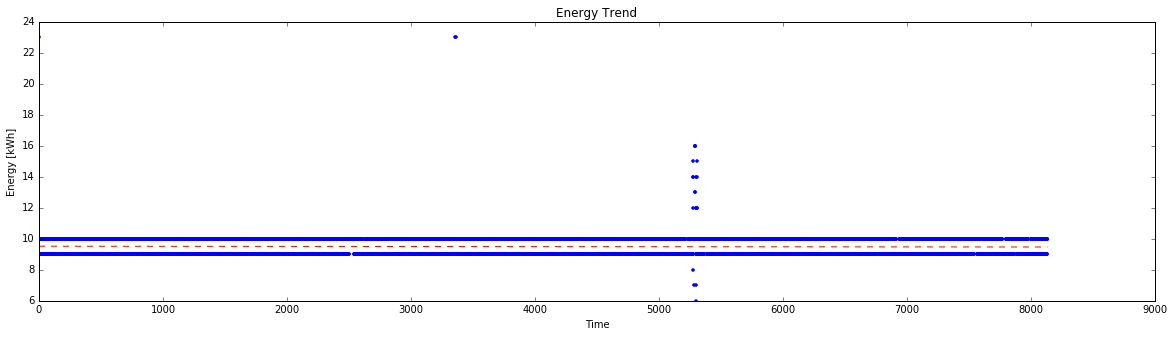

function:  
-7.958e-06 x + 9.58


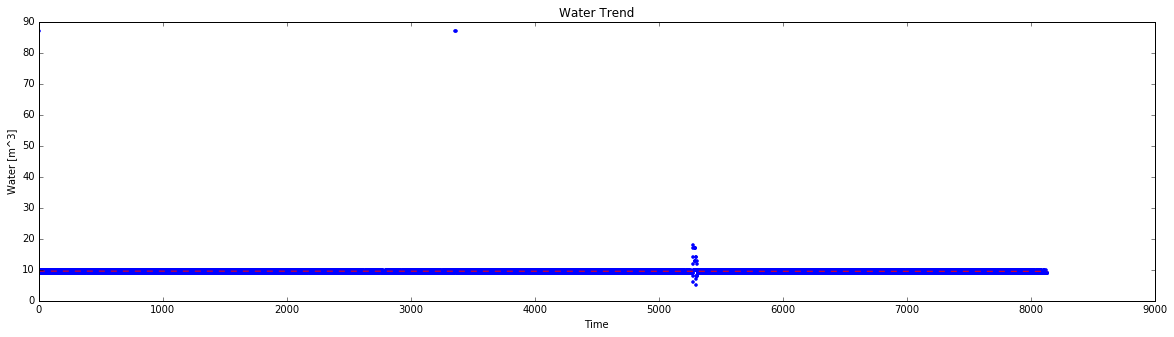

In [104]:
compute_trend(temp,"Temperature","Temperature [C]")
compute_trend(humidity,"Humidity","Humidity [%]")
compute_trend(energy,"Energy","Energy [kWh]")
compute_trend(water,"Water","Water [m^3]")

## 2) How high is the mold risk?

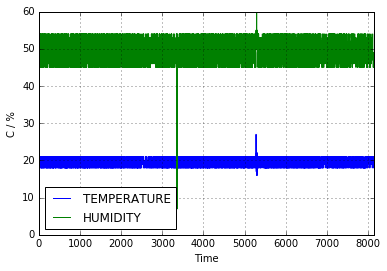

In [93]:
mold = df.select(df.TEMPERATURE, df.HUMIDITY).toPandas()
ax2 = mold.plot()
ax2.set_ylabel("C / %")
ax2.set_xlabel("Time")
ax2.yaxis.grid()
ax2.xaxis.grid()

## 3) What is the monthly average of everything?

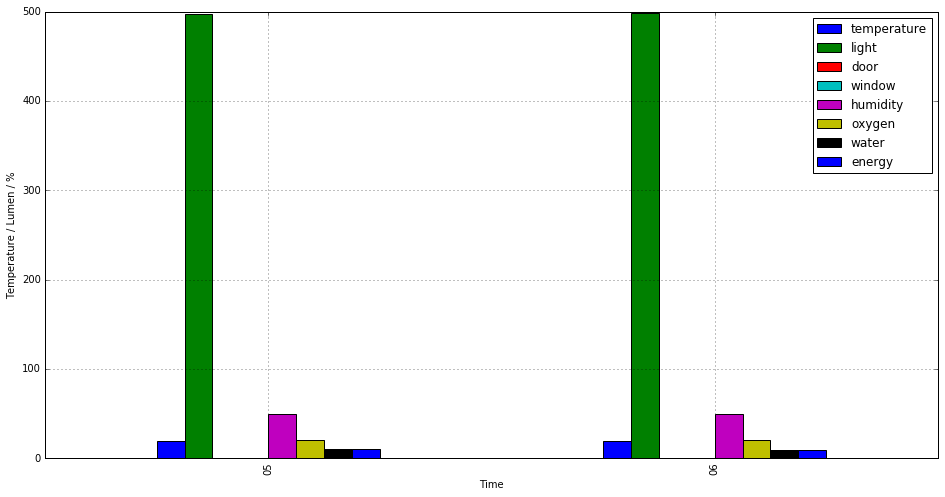

In [94]:
meanm = df_date.groupBy("MONTH").avg().toPandas()
ax3 = meanm.plot(kind="bar",figsize=(16,8),x='MONTH')
ax3.set_ylabel("Temperature / Lumen / %")
ax3.set_xlabel("Time")
ax3.yaxis.grid()
ax3.xaxis.grid()
patches, labels = ax3.get_legend_handles_labels()
ax3.legend(patches, ['temperature','light','door','window','humidity','oxygen','water','energy'], loc='best')

## 4) What is the yearly average of everything?

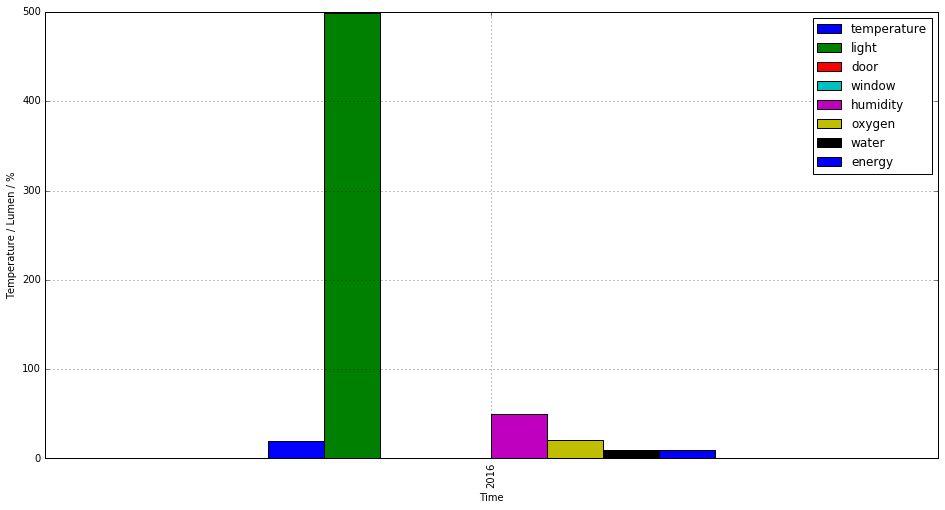

In [95]:
meany = df_date.groupBy("YEAR").avg().toPandas()
ax4 = meany.plot(kind="bar",figsize=(16,8),x='YEAR')
ax4.set_ylabel("Temperature / Lumen / %")
ax4.set_xlabel("Time")
ax4.yaxis.grid()
ax4.xaxis.grid()
patches, labels = ax4.get_legend_handles_labels()
ax4.legend(patches, ['temperature','light','door','window','humidity','oxygen','water','energy'], loc='best')

## 5) Average Monthly Energy and Water Costs

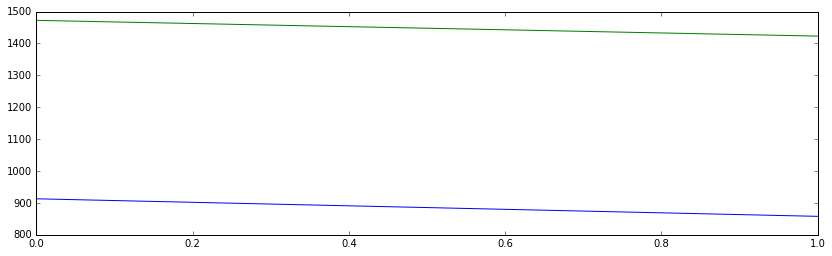

In [96]:
def energycost(x):
    return x * 150

def watercost(x):
    return x * 90
# apply functions
wc=meanm['avg(WATERCONSUMPTION)'].apply(watercost)
ec=meanm['avg(ENERGYCONSUMPTION)'].apply(energycost)
# plot
ax_costs = wc.plot(figsize = (14,4))
ax_costs = ec.plot()

## 6) Energyconsumption in Relation to Temperature

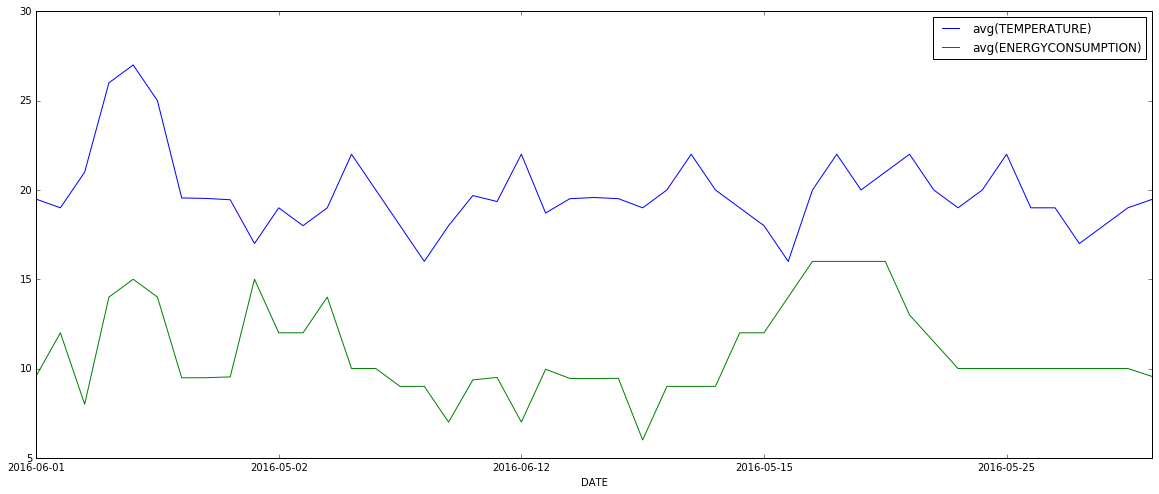

In [97]:
energy_temp = df_date.select(df_date.DATE, df_date.TEMPERATURE, df_date.ENERGYCONSUMPTION)
energy_temp_m = energy_temp.groupBy("DATE").mean()
energy_temp_pd = energy_temp_m.toPandas()
energy_temp_pd.plot(figsize=(20,8), x="DATE")

## 6) Inside Temperature in Relation with Weather
You can download weather data from the Deutsches Wetter Dienst (Germany only). With their service Weste XL you can configure the data, period and location of the measurement. To use the service you first have to create a free account:
http://www.dwd.de/DE/leistungen/weste/westexl/weste_xl.html?nn=342632

Then you can follow the simple steps to download a customized set of data.
- Tageswerte
- Auswahl: Luftemperatur Tagesmittel
- Auswertzeitraum: 01.01.2016 till today
- Ort: Stuttgart

### Add CSV File
(Check that the CSV delimiter is a comma ',')

Go to the Data Source tab on the right hand menu, add source, from file, and select the CSV file you downloaded. Next, select the line below and click on "Insert to code". The name of the credentials object should be credentials_1.

In [98]:
credentials_1 = {
  'auth_uri':'',
  'global_account_auth_uri':'',
  'username':'Admin_261fb56242985b03fe5fb5ad038cce08f399fad7',
  'password':"""MiPY^O/#V2?Rvy]6""",
  'auth_url':'https://identity.open.softlayer.com',
  'project':'object_storage_0d7480c8_58c8_47d8_bb23_268700d555dc',
  'project_id':'0dfe82efbdea4c7c989077b8a7d34319',
  'region':'dallas',
  'user_id':'e69bbff409204a589a0cbf64fd1efd13',
  'domain_id':'0edc67ae808a4936a925c58bb2676c8c',
  'domain_name':'974593',
  'filename':'weather-01.01.16-13.06.16.csv',
  'container':'my-container',
  'tenantId':'s241-c877a956da5ae9-57faa236fbd4'
}

In [99]:
import requests, StringIO, json

def get_file_content(credentials):
    """For given credentials, this functions returns a StringIO object containg the file content 
    from the associated Bluemix Object Storage V3."""

    url1 = ''.join([credentials['auth_url'], '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': credentials['username'],'domain': {'id': credentials['domain_id']},
            'password': credentials['password']}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                if(e2['interface']=='public'and e2['region']==credentials['region']):
                    url2 = ''.join([e2['url'],'/', credentials['container'], '/', credentials['filename']])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO.StringIO(resp2.content)

Pandas from CSV:

In [100]:
# default sep "," if not set with sep=";" or so
weather_csv = pd.read_csv(get_file_content(credentials_1), sep=',')
# we just need the date and value column
weather_csv = weather_csv[['Datum','Wert']]
# rename column names (so we can join on DATE)
weather_csv.columns = ['DATE','temperature_outside']

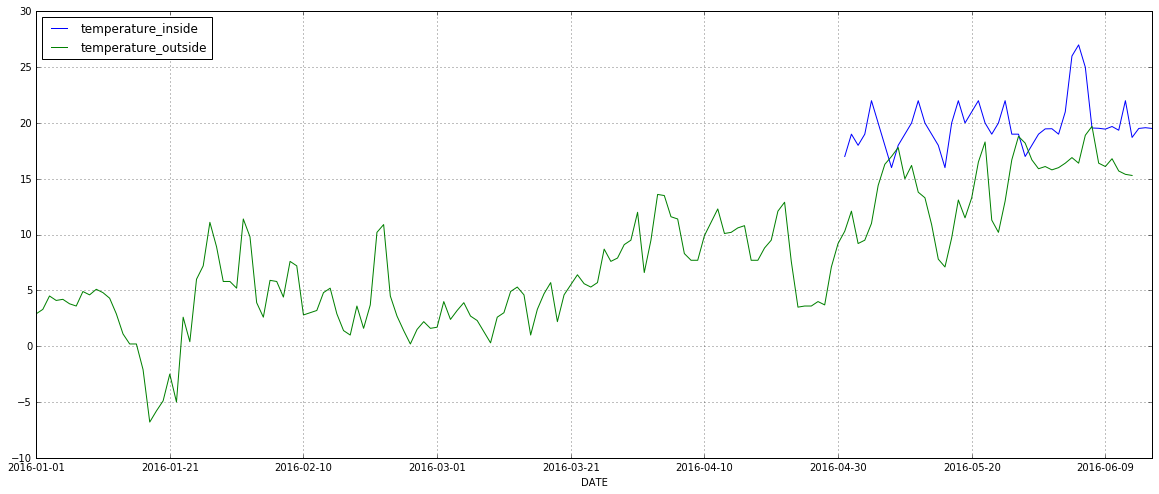

In [101]:
# create DataFrame with sensor data
temp_inside = df_date.select(df_date.TEMPERATURE, df_date.DATE)
temp_inside = temp_inside.groupBy("DATE").avg("TEMPERATURE")
temp_inside = temp_inside.withColumnRenamed("avg(TEMPERATURE)","temperature_inside")
temp_inside = temp_inside.toPandas()
# outer join DataFrames on DATE column
temp_in_out = pd.merge(temp_inside, weather_csv, on="DATE",how="outer")
# sort values by date column
sorted_tio = temp_in_out.sort_values(by=["DATE"])
# plot
sorted_tio.plot(x="DATE", figsize=(20,8), grid=True)